
# Prepare your own dataset for DiffSinger (MIDI-less version)

## 1 Overview

This Jupyter Notebook will guide you to prepare your own dataset for DiffSinger with 44.1 kHz sampling rate.
Please read and follow the guidance carefully, take actions when there are notice for <font color="red">manual action</font> and pay attention to blocks marked with <font color="red">optional step</font>.

### 1.1 Introduction to this pipeline and MIDI-less version

This pipeline does not support customized phoneme dictionaries. It uses the [opencpop strict pinyin dictionary](../dictionaries/opencpop-extension.txt) by default.

MIDI-less version is a simplified version of DiffSinger where MIDI layers, word layers and slur layers are removed from the data labels. The model uses raw phoneme sequence with durations as input, and applies pitch embedding directly from the ground truth. Predictors for phoneme durations and pitch curve are also removed. Below are some limitations and advantages of the MIDI-less version:

- The model will not predict phoneme durations and f0 sequence by itself. You must specify `ph_dur` and `f0_seq` at inference time.
- Performance of pitch control will be better than MIDI-A version, because MIDI keys are misleading information for the diffusion decoder when f0 sequence is already embedded.
- MIDIs and slurs does not need to be labeled, thus the labeling work is easier than other versions.
- More varieties of data can be used as training materials, even including speech.

### 1.2 Install dependencies

Please run the following cell the first time you start this notebook.

**Note**: You should ensure you are in a Conda environment with Python 3.8 or 3.9 before you install dependencies of this pipeline.


In [1]:
%conda install -c conda-forge montreal-forced-aligner==2.0.6 --yes
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: E:\anaconda3\envs\diff

  added / updated specs:
    - montreal-forced-aligner==2.0.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ansiwrap-0.8.4             |             py_0           9 KB  conda-forge
    aom-3.5.0                  |       h63175ca_0        11.7 MB  conda-forge
    audioread-3.0.0            |   py38haa244fe_1          34 KB  conda-forge
    baumwelch-0.3.7            |       hdcb2ade_3         1.5 MB  conda-forge
    biopython-1.79             |   py38h91455d4_3         2.6 MB  conda-forge
    brotli-1.0.9               |       hcfcfb64_8          19 KB  conda-forge
    brotli-bin-1.0.9           |       hcfcfb64_8



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda





     ---------------------------------------- 0.0/214.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/214.3 kB ? eta -:--:--
     ----- ------------------------------- 30.7/214.3 kB 445.2 kB/s eta 0:00:01
     ----- ------------------------------- 30.7/214.3 kB 445.2 kB/s eta 0:00:01
     ----- ------------------------------- 30.7/214.3 kB 445.2 kB/s eta 0:00:01
     ------- ----------------------------- 41.0/214.3 kB 164.3 kB/s eta 0:00:02
     -------------- ---------------------- 81.9/214.3 kB 286.7 kB/s eta 0:00:01
     ------------------ ----------------- 112.6/214.3 kB 345.9 kB/s eta 0:00:01
     ------------------ ----------------- 112.6/214.3 kB 345.9 kB/s eta 0:00:01
     -------------------- --------------- 122.9/214.3 kB 288.8 kB/s eta 0:00:01
     ----------------------------- ------ 174.1/214.3 kB 374.9 kB/s eta 0:00:01
     ------------------------------------ 214.3/214.3 kB 436.1 kB/s eta 0:00:00
     ---------------------------------------- 0.0/8.

### 1.3 Initializing environment

Please run the following cell every time you start this notebook.


In [2]:
import glob
import os
import shutil
import sys

import librosa
import matplotlib.pyplot as plt
import numpy as np
import parselmouth as pm
import soundfile
import textgrid as tg
import tqdm


def length(src: str):
    if os.path.isfile(src) and src.endswith('.wav'):
        return librosa.get_duration(filename=src) / 3600.
    elif os.path.isdir(src):
        total = 0
        for ch in [os.path.join(src, c) for c in os.listdir(src)]:
            total += length(ch)
        return total
    return 0


print('Environment initialized successfully.')


Environment initialized successfully.


## 2 Raw recordings and audio slicing

### 2.1 Choose raw recordings

Your recordings must meet the following conditions:

1. They must be in one single folder. Files in sub-folders will be ignored.
2. They must be in WAV format.
3. They must have a sampling rate higher than 32 kHz.
4. They should be clean, unaccompanied voices with no significant noise or reverb.
5. They should contain only voices from one single human.

<font color="#66ccff">NOTICE</font>: Before you train a model, you must obtain permission from the copyright holder of the dataset and make sure the provider is fully aware that you will train a model from their data, that you will or will not distribute the synthesized voices and model weights, and the potential risks of this kind of activity.

> **Tips for building multiple datasets to train combined models**
>
> If you have multiple speakers/singers, or you have multiple styles/timbres from one person, please make one dataset for each speaker/singer/style/timbre separately. Then you are able to configure parameters and settings for preprocessing and training combined models from these datasets following instructions in **Section 5** of this pipeline.

<font color="red">Optional step</font>: The raw data must be sliced into parts of about 5-15 seconds. If you want to do this yourself, please skip to section 2.3. Otherwise, please edit paths in the following cell before you run it.


In [ ]:
########################################

# Configuration for data paths
raw_path = r'path/to/your/raw/recordings'  # Path to your raw, unsliced recordings

########################################

assert os.path.exists(raw_path) and os.path.isdir(raw_path), 'The chosen path does not exist or is not a directory.'
print('Raw recording path:', raw_path)
print()
print('===== Recording List =====')
raw_filelist = glob.glob(f'{raw_path}/*.wav', recursive=True)
raw_length = length(raw_path)
if len(raw_filelist) > 5:
    print('\n'.join(raw_filelist[:5] + [f'... ({len(raw_filelist) - 5} more)']))
else:
    print('\n'.join(raw_filelist))
print()
print(f'Found {len(raw_filelist)} valid recordings with total length of {round(raw_length, 2)} hours.')


### 2.2 Audio slicing

We provide an audio slicer which automatically cuts recordings into short pieces.

The audio slicer is based on silence detection and has several arguments that have to be specified. You should modify these arguments according to your data.

For more details of each argument, see its [GitHub repository](https://github.com/openvpi/audio-slicer).

Please edit paths and arguments in the following cell before you run it.


In [ ]:
########################################

# Configuration for data paths
sliced_path = r'path/to/your/sliced/recordings'  # Path to hold the sliced segments of your recordings

# Slicer arguments
db_threshold_ = -40.
min_length_ = 5000
min_interval_ = 300
hop_size_ = 10
max_sil_kept_ = 500

########################################

assert 'raw_path' in locals().keys(), 'Raw path of your recordings has not been specified.'
assert not os.path.exists(sliced_path) or os.path.isdir(sliced_path), 'The chosen path is not a directory.'
os.makedirs(sliced_path, exist_ok=True)
print('Sliced recording path:', sliced_path)

from utils.slicer2 import Slicer

for file in tqdm.tqdm(raw_filelist):
    y, sr = librosa.load(file, sr=None, mono=True)
    slicer = Slicer(
        sr=sr,
        threshold=db_threshold_,
        min_length=min_length_,
        min_interval=min_interval_,
        hop_size=hop_size_,
        max_sil_kept=max_sil_kept_
    )
    chunks = slicer.slice(y)
    for i, chunk in enumerate(chunks):
        soundfile.write(os.path.join(sliced_path, f'%s_slice_%04d.wav' % (os.path.basename(file).rsplit('.', maxsplit=1)[0], i)), chunk, sr)

print()
print('===== Segment List =====')
sliced_filelist = glob.glob(f'{sliced_path}/*.wav', recursive=True)
sliced_length = length(sliced_path)
if len(sliced_filelist) > 5:
    print('\n'.join(sliced_filelist[:5] + [f'... ({len(sliced_filelist) - 5} more)']))
else:
    print('\n'.join(sliced_filelist))
print()
print(f'Sliced your recordings into {len(sliced_filelist)} segments with total length of {round(sliced_length, 2)} hours.')


### 2.3 Validating recording segments

In this section, we validate your recording segments.

<font color="red">Optional step</font>: If you skipped section 2.2, please specify the path to your sliced recordings in the following cell and run it. Otherwise, skip this cell.


In [30]:
########################################

# Configuration for data paths
sliced_path = r'C:\Users\12982\Desktop\qiepian'  # Path to your sliced segments of recordings

########################################

assert os.path.exists(sliced_path) and os.path.isdir(sliced_path), 'The chosen path does not exist or is not a directory.'

print('Sliced recording path:', sliced_path)
print()
print('===== Segment List =====')
sliced_filelist = glob.glob(f'{sliced_path}/*.wav', recursive=True)
sliced_length = length(sliced_path)
if len(sliced_filelist) > 5:
    print('\n'.join(sliced_filelist[:5] + [f'... ({len(sliced_filelist) - 5} more)']))
else:
    print('\n'.join(sliced_filelist))
print()
print(f'Found {len(sliced_filelist)} valid segments with total length of {round(sliced_length, 2)} hours.')


Sliced recording path: C:\Users\12982\Desktop\qiepian

===== Segment List =====
C:\Users\12982\Desktop\qiepian\Liyuan Road 2_0.wav
C:\Users\12982\Desktop\qiepian\Liyuan Road 2_1.wav
C:\Users\12982\Desktop\qiepian\Liyuan Road 2_10.wav
C:\Users\12982\Desktop\qiepian\Liyuan Road 2_100.wav
C:\Users\12982\Desktop\qiepian\Liyuan Road 2_101.wav
... (532 more)

Found 537 valid segments with total length of 1.02 hours.


Run the following cell to check if there are segments with an unexpected length (less than 2 seconds or more than 20 seconds).


In [31]:
reported = False
for file in tqdm.tqdm(sliced_filelist):
    wave_seconds = librosa.get_duration(filename=file)
    if wave_seconds < 2.:
        reported = True
        print(f'Too short! \'{file}\' has a length of {round(wave_seconds, 1)} seconds!')
    if wave_seconds > 20.:
        reported = True
        print(f'Too long! \'{file}\' has a length of {round(wave_seconds, 1)} seconds!')
if not reported:
    print('Congratulations! All segments have proper length.')


100%|███████████████████████████████████| 537/537 [00:00<00:00, 3959.41it/s]


Congratulations! All segments have proper length.


<font color="red">Manual action</font>: please consider removing segments too short and manually slicing segments to long, as reported above.

Move on when this is done or there are no segments reported.


## 3 Label your segments

### 3.1 Label syllable sequence

All segments should have their transcriptions (or lyrics) annotated. Run the following cell to see the example segment (from Opencpop dataset) and its corresponding annotation.


In [5]:
from IPython.display import Audio

# noinspection PyTypeChecker
display(Audio(filename='assets/2001000001.wav'))
with open('assets/2001000001.lab', 'r') as f:
    print(f.read())


gan shou ting zai wo fa duan de zhi jian


<font color="red">Manual action</font>: now your task is to annotation transcriptions for each segment like the example shown above.

Each segment should have one annotation file with the same filename as it and `.lab` extension, and placed in the same directory. In the annotation file, you should write all syllables sung or spoken in this segment. Syllables should be split by space, and only syllables that appears in the dictionary are allowed. In addition, all phonemes in the dictionary should be covered in the annotations.

**Special notes**: `AP` and `SP` should not appear in the annotation.

**News**:  We developed [MinLabel](https://github.com/SineStriker/qsynthesis-revenge/tree/main/src/Test/MinLabel), a simple yet efficient tool to help finishing this step. You can download the binary executable for Windows [here](https://huggingface.co/datasets/fox7005/tool/resolve/main/MinLabel%200.0.1.6.zip).

<font color="red">Optional step</font>: if you want us to help you create all empty `lab` files (instead of creating them yourself), please run the following cell.


In [ ]:
for file in tqdm.tqdm(sliced_filelist):
    filename = os.path.basename(file)
    name_without_ext = filename.rsplit('.', maxsplit=1)[0]
    annotation = os.path.join(sliced_path, f'{name_without_ext}.lab')
    if not os.path.exists(annotation):
        with open(annotation, 'a'):
            ...
print('Creating missing lab files done.')


Run the following cell to see if all segments are annotated and all annotations are valid. If there are failed checks, please fix them and run again.

A summary of your phoneme coverage will be generated. If there are some phonemes that have extremely few occurrences (for example, less than 20), it is highly recommended to add more recordings to cover these phonemes.


  0%|                                               | 0/537 [00:00<?, ?it/s]

Syllable(s) ['Let', 'it', 'go', 'Let', 'it', 'go'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_150.lab'
Syllable(s) ['K'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_212.lab'
Syllable(s) ['MV'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_213.lab'
Syllable(s) ['Let', 'get', 'off', 'the', 'bus', 'Take', 'to', 'anywhere'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_349.lab'
Syllable(s) ['It', 's', 'time', 'to', 'wake', 'up'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_351.lab'
Syllable(s) ['It', 's', 'time', 'to', 'save', 'the', 'day'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_353.lab'
Syllable(s) ['n', 'n', 'n', 'n', 'n', 'n'] not allowed in annotation file 'C:\Users\12982\Desktop\qiepian\Liyuan Road 2_410.lab'


100%|███████████████████████████████████| 537/537 [00:00<00:00, 3565.01it/s]


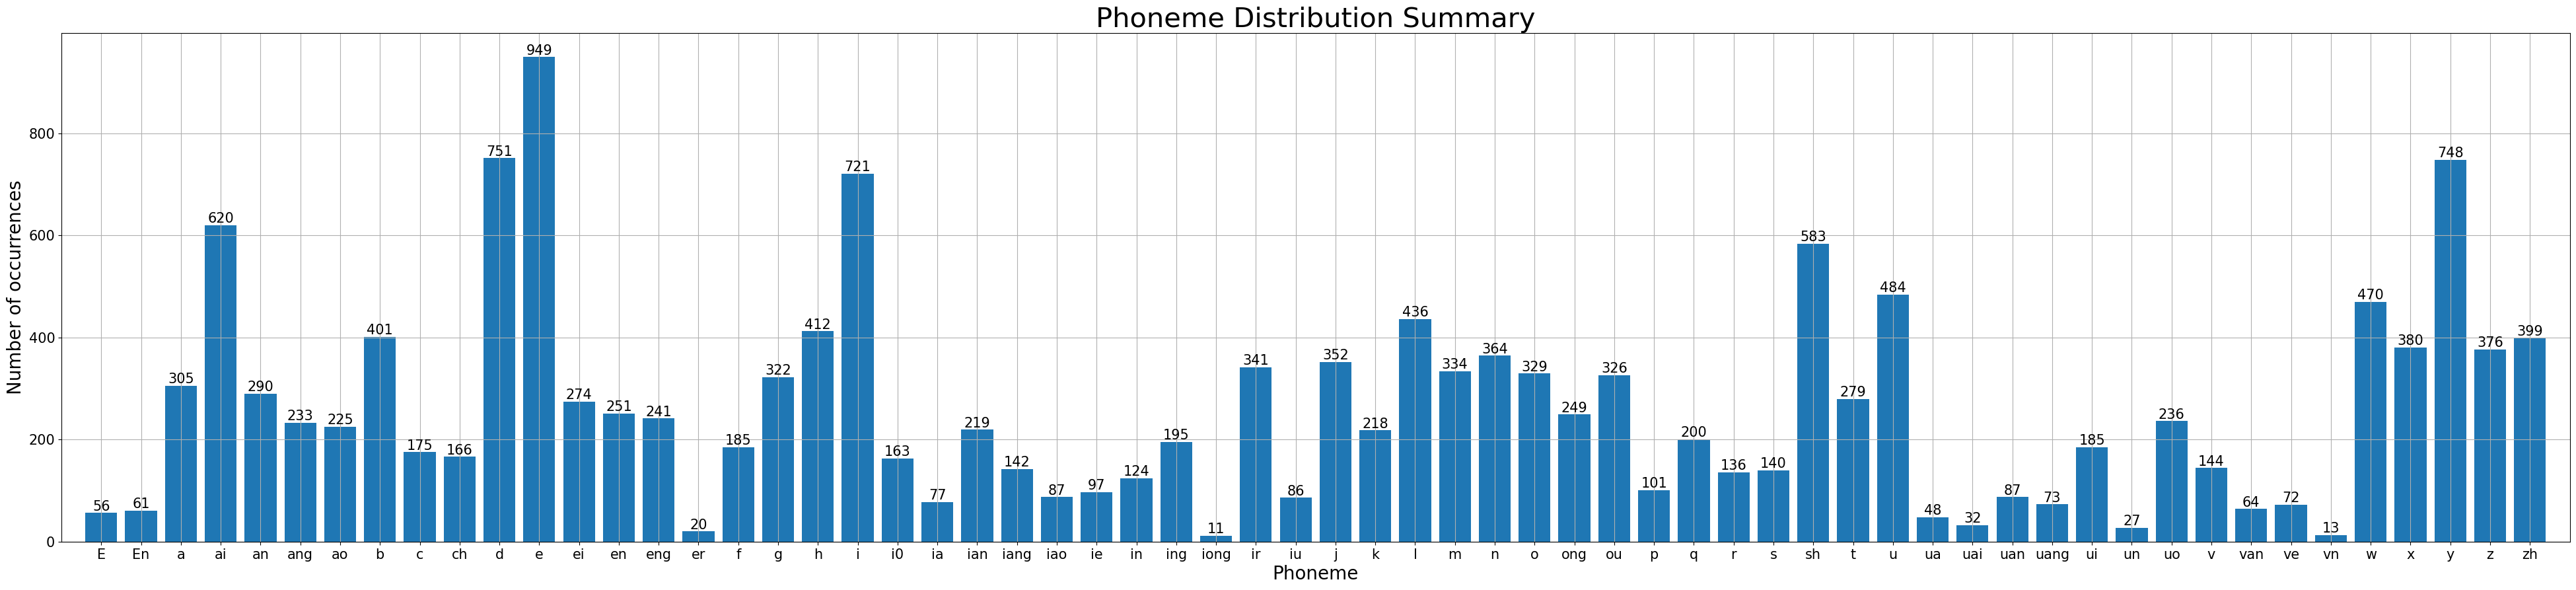

Summary saved to 'C:\Users\12982\Desktop\qiepian\phoneme_distribution.jpg'.


In [32]:
import utils.distribution as dist

# Load dictionary
dict_path = '../dictionaries/opencpop-extension.txt'
with open(dict_path, 'r', encoding='utf8') as f:
    rules = [ln.strip().split('\t') for ln in f.readlines()]
dictionary = {}
phoneme_set = set()
for r in rules:
    phonemes = r[1].split()
    dictionary[r[0]] = phonemes
    phoneme_set.update(phonemes)

# Run checks
check_failed = False
covered = set()
phoneme_map = {}
for ph in sorted(phoneme_set):
    phoneme_map[ph] = 0

segment_pairs = []

for file in tqdm.tqdm(sliced_filelist):
    filename = os.path.basename(file)
    name_without_ext = filename.rsplit('.', maxsplit=1)[0]
    annotation = os.path.join(sliced_path, f'{name_without_ext}.lab')
    if not os.path.exists(annotation):
        print(f'No annotation found for \'{filename}\'!')
        check_failed = True
        continue
    with open(annotation, 'r', encoding='utf8') as f:
        syllables = f.read().strip().split()
    if not syllables:
        print(f'Annotation file \'{annotation}\' is empty!')
        check_failed = True
    else:
        oov = []
        for s in syllables:
            if s not in dictionary:
                oov.append(s)
            else:
                for ph in dictionary[s]:
                    phoneme_map[ph] += 1
                covered.update(dictionary[s])
        if oov:
            print(f'Syllable(s) {oov} not allowed in annotation file \'{annotation}\'')
            check_failed = True

# Phoneme coverage
uncovered = phoneme_set - covered
if uncovered:
    print(f'The following phonemes are not covered!')
    print(sorted(uncovered))
    print('Please add more recordings to cover these phonemes.')
    check_failed = True

if not check_failed:
    print('Congratulations! All annotations are well prepared.')
    print('Here is a summary of your phoneme coverage.')

phoneme_list = sorted(phoneme_set)
phoneme_counts = [phoneme_map[ph] for ph in phoneme_list]
dist.draw_distribution(
    title='Phoneme Distribution Summary',
    x_label='Phoneme',
    y_label='Number of occurrences',
    items=phoneme_list,
    values=phoneme_counts
)
phoneme_summary = os.path.join(sliced_path, 'phoneme_distribution.jpg')
plt.savefig(fname=phoneme_summary,
            bbox_inches='tight',
            pad_inches=0.25)
plt.show()
print(f'Summary saved to \'{phoneme_summary}\'.')


### 3.2 Forced alignment

Given the transcriptions of each segment, we are able to align the phoneme sequence to its corresponding audio, thus obtaining position and duration information of each phoneme.

We use [Montreal Forced Aligner](https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner) to do forced phoneme alignment.

To run MFA alignment, please first run the following cell to resample all recordings to 16 kHz. The resampled recordings and copies of the phoneme labels will be saved at `pipelines/segments/`. Also, the folder `pipelines/textgrids/` will be created for temporarily storing aligned TextGrids.

<font color="yellow">WARNING</font>: This will overwrite all files in `pipelines/segments/` and `pipelines/textgrids/`.


In [33]:
segments_dir = 'segments'
textgrids_dir = 'textgrids'
if os.path.exists(segments_dir):
    shutil.rmtree(segments_dir)
os.makedirs(segments_dir)
if os.path.exists(textgrids_dir):
    shutil.rmtree(textgrids_dir)
os.makedirs(textgrids_dir)
samplerate = 16000
for file in tqdm.tqdm(sliced_filelist):
    y, _ = librosa.load(file, sr=samplerate, mono=True)
    filename = os.path.basename(file)
    soundfile.write(os.path.join(segments_dir, filename), y, samplerate, subtype='PCM_16')
    name_without_ext = filename.rsplit('.', maxsplit=1)[0]
    annotation = os.path.join(sliced_path, f'{name_without_ext}.lab')
    shutil.copy(annotation, segments_dir)
print('Resampling and copying done.')


100%|█████████████████████████████████████| 537/537 [01:46<00:00,  5.04it/s]


Resampling and copying done.


Run the following cell to download the MFA pretrained model and perform forced alignment. You may edit the --beam argument of MFA according to your dataset: Longer segments and worse quality requires larger beams.

This cell also checks if alignments for all segments are sucessfully generated. If the checks fail, there are probably severe errors in your labels, or your segments are too long, or you did not use a proper --beam value.


In [34]:
import requests

mfa_zip = f'assets/mfa-opencpop-extension.zip'
mfa_uri = 'https://huggingface.co/datasets/fox7005/tool/resolve/main/mfa-opencpop-extension.zip'
if not os.path.exists(mfa_zip):
    # Download
    print('Model not found, downloading...')
    with open(mfa_zip, 'wb') as f:
        f.write(requests.get(mfa_uri).content)
    print('Done.')
else:
    pass

segments_dir = 'segments'
textgrids_dir = 'textgrids'
os.makedirs(textgrids_dir, exist_ok=True)

import montreal_forced_aligner

sys.argv = [
    'mfa',
    'align',
    segments_dir,
    dict_path,
    mfa_zip,
    textgrids_dir,
    '--beam',
    '100',  # Edit --beam here.
    '--clean',
    '--overwrite'
]
montreal_forced_aligner.command_line.mfa.main()

print('Checking aligments...')
missing = []
for wavfile in tqdm.tqdm(sliced_filelist):
    name = os.path.basename(wavfile).rsplit('.', maxsplit=1)[0]
    tgfile = os.path.join(textgrids_dir, f'{name}.TextGrid')
    if not os.path.exists(tgfile):
        missing.append(tgfile)
if len(missing) > 0:
    print('These TextGrids are missing! There are possible severe errors in labels of those corresponding segments. '
          'If you do believe there are no errors, consider increase the \'--beam\' argument for MFA.')
    for fn in missing:
        print(f' - {fn}')
else:
    print('All alignments have been successfully generated. Please move on.')


INFO - Setting up corpus information...
INFO - Loading corpus from source files...


100%|█████████████████████████████████████| 537/537 [00:07<00:00, 73.06it/s]


INFO - Found 1 speaker across 537 files, average number of utterances per speaker: 537.0
INFO - Initializing multiprocessing jobs...
WARNING - Number of jobs was specified as 3, but due to only having 1 speakers, MFA will only use 1 jobs.
INFO - Creating corpus split for feature generation...
INFO - Generating base features (mfcc)...
INFO - Generating MFCCs...


 99%|████████████████████████████████████▌| 530/537 [00:20<00:00, 25.67it/s]


INFO - Calculating CMVN...
INFO - Creating corpus split with features...
INFO - Compiling training graphs...


100%|█████████████████████████████████████| 537/537 [00:06<00:00, 78.11it/s]


INFO - Performing first-pass alignment...
INFO - Generating alignments...


100%|█████████████████████████████████████| 537/537 [01:26<00:00,  6.22it/s]


INFO - Calculating fMLLR for speaker adaptation...


100%|█████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


INFO - Performing second-pass alignment...
INFO - Generating alignments...


100%|█████████████████████████████████████| 537/537 [01:18<00:00,  6.87it/s]


INFO - Exporting TextGrids to textgrids...
INFO - Collecting phone and word alignments from alignment lattices...


100%|████████████████████████████████████| 537/537 [00:03<00:00, 172.98it/s]


INFO - Finished exporting TextGrids to textgrids!
INFO - Done! Everything took 228.19134736061096 seconds
Checking aligments...


100%|██████████████████████████████████| 537/537 [00:00<00:00, 14553.30it/s]


All alignments have been successfully generated. Please move on.


### 3.3 Optimize and finish the TextGrids

In this section, we run some scripts to reduce errors for long utterances and detect `AP`s which have not been labeled before. The optimized TextGrids can be saved for future use if you specify a backup directory in the following cell.

Edit the path and adjust arguments according to your needs in the following cell before you run it. Optimized results will be saved at `pipelines/textgrids/revised/`.


In [35]:
########################################

# Configuration for voice arguments based on your dataset
f0_min = 40.  # Minimum value of pitch
f0_max = 1100.  # Maximum value of pitch
br_len = 0.1  # Minimum length of aspiration in seconds
br_db = -60.  # Threshold of RMS in dB for detecting aspiration
br_centroid = 2000.  # Threshold of spectral centroid in Hz for detecting aspiration

# Other arguments, do not edit unless you understand them
time_step = 0.005  # Time step for feature extraction
min_space = 0.04  # Minimum length of space in seconds
voicing_thresh_vowel = 0.45  # Threshold of voicing for fixing long utterances
voicing_thresh_breath = 0.6  # Threshold of voicing for detecting aspiration
br_win_sz = 0.05  # Size of sliding window in seconds for detecting aspiration

########################################

# import utils.tg_optimizer as optimizer

textgrids_revised_dir = 'textgrids/revised'
os.makedirs(textgrids_revised_dir, exist_ok=True)
for wavfile in tqdm.tqdm(sliced_filelist):
    name = os.path.basename(wavfile).rsplit('.', maxsplit=1)[0]
    textgrid = tg.TextGrid()
    textgrid.read(os.path.join(textgrids_dir, f'{name}.TextGrid'))
    words = textgrid[0]
    phones = textgrid[1]
    sound = pm.Sound(wavfile)
    f0_voicing_breath = sound.to_pitch_ac(
        time_step=time_step,
        voicing_threshold=voicing_thresh_breath,
        pitch_floor=f0_min,
        pitch_ceiling=f0_max,
    ).selected_array['frequency']
    f0_voicing_vowel = sound.to_pitch_ac(
        time_step=time_step,
        voicing_threshold=voicing_thresh_vowel,
        pitch_floor=f0_min,
        pitch_ceiling=f0_max,
    ).selected_array['frequency']
    y, sr = librosa.load(wavfile, sr=24000, mono=True)
    hop_size = int(time_step * sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=2048, hop_length=hop_size).squeeze(0)

    # Fix long utterances
    i = j = 0
    while i < len(words):
        word = words[i]
        phone = phones[j]
        if word.mark is not None and word.mark != '':
            i += 1
            j += len(dictionary[word.mark])
            continue
        if i == 0:
            i += 1
            j += 1
            continue
        prev_word = words[i - 1]
        prev_phone = phones[j - 1]
        # Extend length of long utterances
        while word.minTime < word.maxTime - time_step:
            pos = min(f0_voicing_vowel.shape[0] - 1, int(word.minTime / time_step))
            if f0_voicing_vowel[pos] < f0_min:
                break
            prev_word.maxTime += time_step
            prev_phone.maxTime += time_step
            word.minTime += time_step
            phone.minTime += time_step
        i += 1
        j += 1

    # Detect aspiration
    i = j = 0
    while i < len(words):
        word = words[i]
        phone = phones[j]
        if word.mark is not None and word.mark != '':
            i += 1
            j += len(dictionary[word.mark])
            continue
        if word.maxTime - word.minTime < br_len:
            i += 1
            j += 1
            continue
        ap_ranges = []
        br_start = None
        win_pos = word.minTime
        while win_pos + br_win_sz <= word.maxTime:
            all_noisy = (f0_voicing_breath[int(win_pos / time_step) : int((win_pos + br_win_sz) / time_step)] < f0_min).all()
            rms_db = 20 * np.log10(np.clip(sound.get_rms(from_time=win_pos, to_time=win_pos + br_win_sz), a_min=1e-12, a_max=1))
            # print(win_pos, win_pos + br_win_sz, all_noisy, rms_db)
            if all_noisy and rms_db >= br_db:
                if br_start is None:
                    br_start = win_pos
            else:
                if br_start is not None:
                    br_end = win_pos + br_win_sz - time_step
                    if br_end - br_start >= br_len:
                        centroid = spectral_centroid[int(br_start / time_step) : int(br_end / time_step)].mean()
                        if centroid >= br_centroid:
                            ap_ranges.append((br_start, br_end))
                    br_start = None
                    win_pos = br_end
            win_pos += time_step
        if br_start is not None:
            br_end = win_pos + br_win_sz - time_step
            if br_end - br_start >= br_len:
                centroid = spectral_centroid[int(br_start / time_step) : int(br_end / time_step)].mean()
                if centroid >= br_centroid:
                    ap_ranges.append((br_start, br_end))
        # print(ap_ranges)
        if len(ap_ranges) == 0:
            i += 1
            j += 1
            continue
        words.removeInterval(word)
        phones.removeInterval(phone)
        if word.minTime < ap_ranges[0][0]:
            words.add(minTime=word.minTime, maxTime=ap_ranges[0][0], mark=None)
            phones.add(minTime=phone.minTime, maxTime=ap_ranges[0][0], mark=None)
            i += 1
            j += 1
        for k, ap in enumerate(ap_ranges):
            if k > 0:
                words.add(minTime=ap_ranges[k - 1][1], maxTime=ap[0], mark=None)
                phones.add(minTime=ap_ranges[k - 1][1], maxTime=ap[0], mark=None)
                i += 1
                j += 1
            words.add(minTime=ap[0], maxTime=min(word.maxTime, ap[1]), mark='AP')
            phones.add(minTime=ap[0], maxTime=min(word.maxTime, ap[1]), mark='AP')
            i += 1
            j += 1
        if ap_ranges[-1][1] < word.maxTime:
            words.add(minTime=ap_ranges[-1][1], maxTime=word.maxTime, mark=None)
            phones.add(minTime=ap_ranges[-1][1], maxTime=phone.maxTime, mark=None)
            i += 1
            j += 1

    # Remove short spaces
    i = j = 0
    while i < len(words):
        word = words[i]
        phone = phones[j]
        if word.mark is not None and word.mark != '':
            i += 1
            j += (1 if word.mark == 'AP' else len(dictionary[word.mark]))
            continue
        if word.maxTime - word.minTime >= min_space:
            word.mark = 'SP'
            phone.mark = 'SP'
            i += 1
            j += 1
            continue
        if i == 0:
            if len(words) >= 2:
                words[i + 1].minTime = word.minTime
                phones[j + 1].minTime = phone.minTime
                words.removeInterval(word)
                phones.removeInterval(phone)
            else:
                break
        elif i == len(words) - 1:
            if len(words) >= 2:
                words[i - 1].maxTime = word.maxTime
                phones[j - 1].maxTime = phone.maxTime
                words.removeInterval(word)
                phones.removeInterval(phone)
            else:
                break
        else:
            words[i - 1].maxTime = words[i + 1].minTime = (word.minTime + word.maxTime) / 2
            phones[j - 1].maxTime = phones[j + 1].minTime = (phone.minTime + phone.maxTime) / 2
            words.removeInterval(word)
            phones.removeInterval(phone)
    textgrid.write(os.path.join(textgrids_revised_dir, f'{name}.TextGrid'))


 11%|████                                  | 58/537 [00:17<02:22,  3.36it/s]


KeyError: 'let'

`TextGrid` saved in `pipelines/textgrids/revised` can be edited via [Praat](https://github.com/praat/praat). You may examine these files and fix label errors by yourself if you want a more accurate model with higher performance. However, this is not required since manual labeling takes much time.

Run the following cell to see summary of word-level pitch coverage of your dataset. (Data may not be accurate due to octave errors in pitch extraction.)


In [24]:
import utils.distribution as dist


def key_to_name(midi_key):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    return note_names[midi_key % 12] + str(midi_key // 12 - 1)


pit_map = {}
if not f0_min in locals():
    f0_min = 40.
if not f0_max in locals():
    f0_max = 1100.
if not voicing_thresh_vowel in locals():
    voicing_thresh_vowel = 0.45
for wavfile in tqdm.tqdm(sliced_filelist):
    name = os.path.basename(wavfile).rsplit('.', maxsplit=1)[0]
    textgrid = tg.TextGrid()
    textgrid.read(os.path.join(textgrids_revised_dir, f'{name}.TextGrid'))
    timestep = 0.01
    f0 = pm.Sound(wavfile).to_pitch_ac(
        time_step=timestep,
        voicing_threshold=voicing_thresh_vowel,
        pitch_floor=f0_min,
        pitch_ceiling=f0_max,
    ).selected_array['frequency']
    pitch = 12. * np.log2(f0 / 440.) + 69.
    for word in textgrid[0]:
        if word.mark in ['AP', 'SP']:
            continue
        if word.maxTime - word.minTime < timestep:
            continue
        word_pit = pitch[int(word.minTime / timestep) : int(word.maxTime / timestep)]
        word_pit = np.extract(word_pit >= 0, word_pit)
        if word_pit.shape[0] == 0:
            continue
        counts = np.bincount(word_pit.astype(np.int64))
        midi = counts.argmax()
        if midi in pit_map:
            pit_map[midi] += 1
        else:
            pit_map[midi] = 1
midi_keys = sorted(pit_map.keys())
midi_keys = list(range(midi_keys[0], midi_keys[-1] + 1))
dist.draw_distribution(
    title='Pitch Distribution Summary',
    x_label='Pitch',
    y_label='Number of occurrences',
    items=[key_to_name(k) for k in midi_keys],
    values=[pit_map.get(k, 0) for k in midi_keys]
)
pitch_summary = os.path.join(sliced_path, 'pitch_distribution.jpg')
plt.savefig(fname=pitch_summary,
            bbox_inches='tight',
            pad_inches=0.25)
plt.show()
print(f'Summary saved to \'{pitch_summary}\'.')


  0%|                                               | 0/538 [00:00<?, ?it/s]C:\Users\12982\AppData\Local\Temp\ipykernel_1540\296893636.py:27: RuntimeWarning: divide by zero encountered in log2
  pitch = 12. * np.log2(f0 / 440.) + 69.
  3%|█                                     | 15/538 [00:00<00:15, 34.18it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'textgrids/revised\\Liyuan Road 2_111.TextGrid'

## 4 Building the final dataset

Congratulations! If you have gone through all sections above with success, it means that you are now prepared for building your final dataset. There are only a few steps to go before you can run scripts to train your own model.

### 4.1 Name and format your dataset

Please provide a unique name for your dataset, usually the name of the singer/speaker (whether real or virtual). For example, `opencpop` will be a good name for the dataset. You can also add tags to represent dataset version, model capacity or improvements. For example, `v2` represents the version, `large` represents the capacity, and `fix_br` means you fixed breaths since your trained last model.

Please edit the following cell before you run it. Remember only using letters, numbers and underlines (`_`).


In [ ]:
########################################

# Name and tags of your dataset
dataset_name = '???'  # Required
dataset_tags = ''  # Optional

########################################

import random
import re

from textgrid import TextGrid

assert dataset_name != '', 'Dataset name cannot be empty.'
assert re.search(r'[^0-9A-Za-z_]', dataset_name) is None, 'Dataset name contains invalid characters.'
full_name = dataset_name
if dataset_tags != '':
    assert re.search(r'[^0-9A-Za-z_]', dataset_name) is None, 'Dataset tags contain invalid characters.'
    full_name += f'_{dataset_tags}'
assert not os.path.exists(f'../data/{full_name}'), f'The name \'{full_name}\' already exists in your \'data\' folder!'

print('Dataset name:', dataset_name)
if dataset_tags != '':
    print('Tags:', dataset_tags)

formatted_path = f'../data/{full_name}/raw/wavs'
os.makedirs(formatted_path)
transcriptions = []
samplerate = 44100
min_sil = int(0.1 * samplerate)
max_sil = int(0.5 * samplerate)
for wavfile in tqdm.tqdm(sliced_filelist):
    name = os.path.basename(wavfile).rsplit('.', maxsplit=1)[0]
    y, _ = librosa.load(wavfile, sr=samplerate, mono=True)
    tg = TextGrid()
    tg.read(os.path.join(textgrids_revised_dir, f'{name}.TextGrid'))
    ph_seq = [ph.mark for ph in tg[1]]
    ph_dur = [ph.maxTime - ph.minTime for ph in tg[1]]
    if random.random() < 0.5:
        len_sil = random.randrange(min_sil, max_sil)
        y = np.concatenate((np.zeros((len_sil,), dtype=np.float32), y))
        if ph_seq[0] == 'SP':
            ph_dur[0] += len_sil / samplerate
        else:
            ph_seq.insert(0, 'SP')
            ph_dur.insert(0, len_sil / samplerate)
    if random.random() < 0.5:
        len_sil = random.randrange(min_sil, max_sil)
        y = np.concatenate((y, np.zeros((len_sil,), dtype=np.float32)))
        if ph_seq[-1] == 'SP':
            ph_dur[-1] += len_sil / samplerate
        else:
            ph_seq.append('SP')
            ph_dur.append(len_sil / samplerate)
    ph_seq = ' '.join(ph_seq)
    ph_dur = ' '.join([str(round(d, 6)) for d in ph_dur])
    soundfile.write(os.path.join(formatted_path, f'{name}.wav'), y, samplerate)
    transcriptions.append(f'{name}|啊|{ph_seq}|rest|0|{ph_dur}|0')
with open(f'../data/{full_name}/raw/transcriptions.txt', 'w', encoding='utf8') as f:
    print('\n'.join(transcriptions), file=f)
print(f'All wavs and transcriptions saved at \'data/{full_name}/raw/\'.')


Now that the dataset and transcriptions have been saved, you can run the following cell to clean up all temporary files generated by pipelines above.

<font color="yellow">WARNING</font>: This will remove `pipelines/segments/` and `pipelines/textgrids/` folders. You should specify a directory in the following cell to back up your TextGrids if you want them for future use.


In [ ]:
########################################

# Optional path to back up your TextGrids
textgrids_backup_path = r''  # If left empty, the TextGrids will not be backed up

########################################

assert textgrids_backup_path == '' or not os.path.exists(textgrids_backup_path) or os.path.isdir(textgrids_backup_path), 'The backup path is not a directory.'

if textgrids_backup_path != '':
    os.makedirs(textgrids_backup_path, exist_ok=True)
    for tg in tqdm.tqdm(glob.glob(f'{textgrids_revised_dir}/*.TextGrid')):
        filename = os.path.basename(tg)
        shutil.copy(tg, os.path.join(textgrids_backup_path, filename))

shutil.rmtree(segments_dir)
shutil.rmtree(textgrids_dir)
print('Cleaning up done.')


### 4.2 Configuring parameters

Here you can configure some parameters for preprocessing, training and the neural networks. Read the explanations below, edit parameters according to your preference, and run the following cell to generate the configuration file.

> You do not need to actually run this cell if you are building multiple datasets to train combined models. In this case, please see instructions in **Section 5**.

#### 4.2.1 The neural networks

These parameters control the capacity and structure of the neural networks.

##### `residual_channels` and `residual_layers`

These two hyperparameters refer to the width and the depth of the diffusion decoder network. Generally speaking, `384x20` represents a `base` model capacity and `512x20` represents a `large` model capacity. `384x30` is also a reasonable choice. Larger models consumes more GPU memory and runs slower at training and inference time, but they produce better results.

GPU memory required for training:

Base model - at least 6 GB (12 GB recommended)
Large model - at least 12 GB (24 GB recommended)

##### `f0_embed_type`

There are two ways of f0 embedding: `discrete` and `continuous`. The discrete embedding takes 256 bins from 50Hz to 1100Hz and embeds the discrete f0 bins with `torch.nn.Embedding`, while the continuous embedding converts f0 to continuous mel frequency and embeds these values with `torch.nn.Linear`.

The discrete embedding has been tested for long and is guaranteed to be stable. The continuous embedding has not been widely tested, but some improvements at the extreme edges of the pitch range were observed.

#### 4.2.2 Data augmentation

Data augmentation improves the performance or functionalities of your model, **but may boost the size of your training data**.

##### `random_pitch_shifting`

Once enabled, the pitch of your data will be randomly shifted without keeping the formant when preprocessing. Besides, the number of keys that each piece of data is shifted will be embedded into the networks. This will broaden the range of pitch and allows you to control the frame-level key shift values (like the GEN parameter in VOCALOID) at inference time.

This type of augmentation accepts the following arguments:
- `range` controls the range of pitch keys that will be randomly shifted.
- `scale` controls the amount of data that the augmentation will be applied to.

$ D_{augmentation} \approx (1 + scale) \cdot D_{original} $

##### `fixed_pitch_shifting`

Once enabled, the pitch of your data will be shifted several numbers of keys. These data with pitch shifting will be marked as different speakers from the original data, **thus making the model a multi-speaker combined model**. This will also broaden the range of pitch (maybe slightly better than random pitch shifting). **This augmentation is not compatible with random pitch shifting.**

This type of augmentation accepts the following arguments:
- `targets` controls the number of targets of pitch shifting and the number of keys that will be shifted towards each target.
- `scale` controls the amount of data that **each target** of the augmentation will be applied to.

$ D_{augmentation} \approx (1 + N \cdot scale) \cdot D_{original} $ , where $ N $ represents the number of targets.

##### `random_time_stretching`

Once enabled, the speed of your data will be randomly changed when preprocessing. The ratio of the speed change will be embedded into the networks, which allows you to control the frame-level speed or velocity (similar to but much more flexible than the VEL parameter in VOCALOID) at inference time. In other words, by applying global time stretching at training time, you gain the ability to apply local time stretching at inference time. This can be used to adjust the texture of consonants and the ratio of different parts of vowels. **Some audio segments will be longer after this augmentation is applied. Please be careful of your batch size and your GPU memory usage.**

This type of augmentation accepts the following arguments:
- `range` controls the range of the speed changing ratio.
- `domain` determines in which domain the speed ratio will follow a uniform distribution in: `log` or `linear`
- `scale` controls the amount of data that the augmentation will be applied to.

$ D_{augmentation} \approx (1 + scale \cdot \frac{1}{b - a} \cdot \int_{a}^{b} f(x) dx) \cdot D_{original} $ , where $ a, b $ represents the range of the speed ratio, $ f(x) $ represents the PDF of the speed ratio.

---
> When there are more than two types of augmentation enabled, a cascade and joint augmentation scaling algorithm is applied. Briefly speaking, the following rules will be satisfied after applying and combining multiple types of augmentation:
> 1. The number of data pieces applied with the $ k $th augmentation will be $ scale_{k} $ times than those not applied with the $ k $th augmentation.
> 2. The number of data pieces applied with at least one type of augmentation will be $ \sum_{i = 1}^{n} scale_{i} $ times than those not applied with any augmentation (purely raw data).

#### 4.2.3 Training and validating

##### `test_prefixes`

All files with name prefixes specified in this list will be put into the test set. Each time when a checkpoint is saved, the program will first run inference on the test set and put the result on the TensorBoard. Thus, you can listen to these demos and judge the quality of your model. If you leave it empty, test cases will be randomly selected.

##### `max_tokens` and `max_sentences`

These two parameters jointly determine the batch size at training time, the former representing maximum number of frames in one batch and the latter limiting the maximum batch size. Larger batches consumes more GPU memory at training time. This value can be adjusted according to your GPU memory. Remember not to set this value too low because the model may not converge with small batches.

##### `lr`, `decay_steps`, `gamma`

The learning rate starts at `lr`, decays with the rate `gamma` at every `decay_steps` during training. If you decreased your batch size, you may consider using a smaller learning rate and more decay steps, or larger gamma.

##### `val_check_interval`, `num_ckpt_keep` and `max_updates`

These three values refer to the training steps between validating and saving checkpoints, the number of the most recent checkpoints reserved, and the maximum training steps. With default batch size and 5 hours of training data, 250k ~ 350k training steps is reasonable. If you decrease the batch size, you may increase the training steps.

##### `permanent_ckpt_start` and `permanent_ckpt_interval`

These two values help you save permanent checkpoints during training. Normally, old checkpoints will be removed and only the newest `num_ckpt_keep` checkpoints will be kept. With these two values, the program will save a permanent checkpoints each `permanent_ckpt_interval` steps after the training reaches `permenant_ckpt_start` steps. Permanent checkpoints will never be removed and can be used for comparison between different training steps and as backups in case of over-fitting.

To enable permanent checkpoints, please ensure these values are positive multiples of `val_check_interval`. To disable permanent checkpoints, please set `permanent_ckpt_interval` to `-1`.


In [ ]:
########################################

# The neural networks
residual_channels = 512
residual_layers = 20
f0_embed_type = 'continuous'

# Data augmentation
random_pitch_shifting = {
    'enabled': False,
    'range': [-5., 5.],
    'scale': 2.
}
fixed_pitch_shifting = {
    'enabled': False,
    'targets': [-5., 5.],
    'scale': 0.75
}
random_time_stretching = {
    'enabled': False,
    'range': [0.5, 2.],
    'domain': 'log',  # or linear
    'scale': 2.
}

# Training and validating
test_prefixes = [

]

max_tokens = 80000
max_sentences = 48

lr = 0.0004
decay_steps = 50000
gamma = 0.5

val_check_interval = 2000
num_ckpt_keep = 5
max_updates = 320000
permanent_ckpt_start = 120000
permanent_ckpt_interval = 40000

########################################

from copy import deepcopy
import datetime
import random

import yaml

training_cases = [os.path.basename(w).rsplit('.', maxsplit=1)[0] for w in sliced_filelist]
valid_test_cases = []
if len(test_prefixes) > 0:
    for prefix in deepcopy(test_prefixes):
        if prefix in training_cases:
            valid_test_cases.append(training_cases)
            test_prefixes.remove(prefix)
            training_cases.remove(prefix)
    i = 0
    while i < len(training_cases):
        for prefix in test_prefixes:
            if training_cases[i].startswith(prefix):
                valid_test_cases.append(training_cases[i])
                training_cases.pop(i)
                i -= 1
                break
        i += 1
else:
    test_prefixes += sorted(random.sample(training_cases, 10))

configs = {
    'base_config': ['configs/acoustic/nomidi.yaml'],
    'speakers': [dataset_name],
    'raw_data_dir': [f'data/{full_name}/raw'],
    'binary_data_dir': f'data/{full_name}/binary',
    'residual_channels': residual_channels,
    'residual_layers': residual_layers,
    'f0_embed_type': f0_embed_type,
    'test_prefixes': test_prefixes,
    'max_tokens': max_tokens,
    'max_sentences': max_sentences,
    'lr': lr,
    'decay_steps': decay_steps,
    'gamma': gamma,
    'val_check_interval': val_check_interval,
    'num_valid_plots': min(10, len(test_prefixes)),
    'num_ckpt_keep': num_ckpt_keep,
    'max_updates': max_updates,
    'permanent_ckpt_start': permanent_ckpt_start,
    'permanent_ckpt_interval': permanent_ckpt_interval
}

augmentation_args = {}
if random_pitch_shifting['enabled']:
    augmentation_args['random_pitch_shifting'] = {
        'range': random_pitch_shifting['range'],
        'scale': random_pitch_shifting['scale']
    }
    configs['use_key_shift_embed'] = True
if fixed_pitch_shifting['enabled']:
    augmentation_args['fixed_pitch_shifting'] = {
        'targets': fixed_pitch_shifting['targets'],
        'scale': fixed_pitch_shifting['scale']
    }
    configs['use_spk_id'] = True
    configs['num_spk'] = 1 + len(fixed_pitch_shifting['targets'])
if random_time_stretching['enabled']:
    augmentation_args['random_time_stretching'] = {
        'range': random_time_stretching['range'],
        'domain': random_time_stretching['domain'],
        'scale': random_time_stretching['scale']
    }
    configs['use_speed_embed'] = True
configs['augmentation_args'] = augmentation_args

with open(f'../data/{full_name}/config.yaml', 'w', encoding='utf8') as f:
    yaml.dump(configs, f, sort_keys=False, allow_unicode=True)

date = datetime.datetime.now().strftime('%m%d')
exp_name = f'{date}_{dataset_name}_ds1000'
if dataset_tags != '':
    exp_name += f'_{dataset_tags}'
print('Congratulations! All steps have been done and you are now prepared to train your own model.\n'
      'Before you start, please read and follow instructions in the repository README.\n'
      'Here are the commands for you to copy that you can run preprocessing and training:\n')

print('============ Linux ============\n'
      'export PYTHONPATH=.\n'
      'export CUDA_VISIBLE_DEVICES=0\n'
      f'python data_gen/binarize.py --config data/{full_name}/config.yaml\n'
      f'python run.py --config data/{full_name}/config.yaml --exp_name {exp_name} --reset\n')

print('===== Windows (PowerShell) =====\n'
      '$env:PYTHONPATH="."\n'
      '$env:CUDA_VISIBLE_DEVICES=0\n'
      f'python data_gen/binarize.py --config data/{full_name}/config.yaml\n'
      f'python run.py --config data/{full_name}/config.yaml --exp_name {exp_name} --reset\n')

print('===== Windows (Command Prompt) =====\n'
      'set PYTHONPATH=.\n'
      'set CUDA_VISIBLE_DEVICES=0\n'
      f'python data_gen/binarize.py --config data/{full_name}/config.yaml\n'
      f'python run.py --config data/{full_name}/config.yaml --exp_name {exp_name} --reset\n')

print(f'If you want to train your model on another machine (like a remote GPU), please copy the whole \'data/{full_name}/\' folder.')


## 5 (Additional section) Configuring multiple datasets for combined models

If you have multiple datasets, you can train a combined model with them for better performance and case coverage. In addition, you gain ability to switch between different speakers/singers/styles/timbres, or even mix any of them in any proportions, static or dynamic over time, via one single model!

This section will guide you to create configuration files for this kind of models, so that you can run joint preprocessing and training from multiple datasets.

<font color="#66ccff">NOTICE</font>: Before you train a combined model, you must obtain permission from copyright holders of each dataset and make sure all these providers are fully aware that you will train a combined model from their data, that you will or will not distribute the synthesized voices and model weights, that their voices will or will not be mixed, and the potential risks of this kind of activity.

### 5.1 Selecting datasets

In the following cell, you can choose the datasets and name your combined model.

##### `model_name` and `model_tags`

Similar to `dataset_name` and `dataset_tags` described in Section 4.1, but here you are able to use `+` in your model name. For example, `female_triplet` and `alice+bob` are nice names for a combined model.

##### `datasets`

Selection of datasets. You specify datasets using their full names and set a speaker name for each dataset. Here is an example:

```python
datasets = [
    {
        'dataset': 'alice',
        'speaker': 'Alice-Normal'
    },
    {
        'dataset': 'alice_sweet',
        'speaker': 'Alice-Sweet'
    },
    {
        'dataset': 'bob_v2',
        'speaker': 'Bob'
    },
]
```
You must type in full names of datasets (folder name in the `data/` directory). You may use letters, numbers, underline (`_`) and hyphens (`-`) in the speaker name.


In [ ]:
########################################

# Name and tags of your combined model
model_name = '???'  # Required
model_tags = ''  # Optional

datasets = [
    {
        'dataset': '???',
        'speaker': '???'
    },
]

########################################

import re

assert model_name != '', 'Model name cannot be empty.'
assert re.search(r'[^0-9A-Za-z_\+]', model_name) is None, 'Model name contains invalid characters.'
model_full_name = model_name
if model_tags != '':
    assert re.search(r'[^0-9A-Za-z_]', model_name) is None, 'Dataset tags contain invalid characters.'
    model_full_name += f'_{model_tags}'
assert not os.path.exists(f'../data/{model_full_name}'), f'The name \'{model_full_name}\' already exists in your \'data\' folder!'

speakers = []
raw_data_dirs = []
for selection in datasets:
    assert selection['dataset'] in os.listdir('../data/'), f'Dataset \'{selection["dataset"]}\' not found.'
    assert os.path.exists(f'../data/{selection["dataset"]}/raw/wavs'), f'Wave directory not found in dataset \'{selection["dataset"]}\''
    assert os.path.exists(f'../data/{selection["dataset"]}/raw/transcriptions.txt'), f'Transcriptions not found in dataset \'{selection["dataset"]}\''
    assert re.search(r'[^0-9A-Za-z_-]', selection['speaker']) is None, 'Speaker name contains invalid characters.'
    speakers.append(selection['speaker'])
    raw_data_dirs.append(f'data/{selection["dataset"]}/raw')

print('Model name:', model_name)
if model_tags != '':
    print('Tags:', model_tags)
os.makedirs(f'../data/{model_full_name}/')
print(f'Created \'data/{model_full_name}/\'')


### 5.2 Configuring parameters

Most parameters for combined models are the same as described in Section 4.2, except the following differences.

##### `random_pitch_shifting`, `fixed_pitch_shifting` and `random_time_stretching`

Please pay attention to the size of your training data!

##### `test_prefixes`

You can use prefixes or full names of wave file, with or without speaker id in this parameter. For example:
- `xxx` will fully match one single filename in any of selected datasets, or if there is none, match all filenames starting with `xxx`.
- `0:xxx` will fully match one single filename in **the first** dataset, or if there is none, match all filenames starting with `xxx` **in that dataset**.

If not specified, test cases will be randomly selected from all datasets.


In [ ]:
########################################

# The neural networks
residual_channels = 512
residual_layers = 20
f0_embed_type = 'continuous'

# Data augmentation
random_pitch_shifting = {
    'enabled': False,
    'range': [-5., 5.],
    'scale': 1.5
}
fixed_pitch_shifting = {
    'enabled': False,
    'targets': [-5., 5.],
    'scale': 0.75
}
random_time_stretching = {
    'enabled': False,
    'range': [0.5, 2.],
    'domain': 'log',  # or linear
    'scale': 1.5
}

# Training and validating
test_prefixes = [

]

max_tokens = 80000
max_sentences = 48

lr = 0.0004
decay_steps = 50000
gamma = 0.5

val_check_interval = 2000
num_ckpt_keep = 5
max_updates = 320000
permanent_ckpt_start = 120000
permanent_ckpt_interval = 40000

########################################

import datetime
import random

import yaml

training_cases = []
for raw_data_dir in raw_data_dirs:
    with open(os.path.join('..', raw_data_dir, 'transcriptions.txt'), 'r', encoding='utf8') as f:
        training_cases.append([line.split('|')[0] for line in f.readlines()])
valid_test_cases = []
if len(test_prefixes) > 0:
    for prefix in deepcopy(test_prefixes):
        if prefix.contains(':'):
            idx, fn = prefix.split(':')
            idx = int(idx)
            if fn in training_cases[idx]:
                valid_test_cases.append(prefix)
                test_prefixes.remove(prefix)
                training_cases[idx].remove(fn)
        else:
            for idx, cases in training_cases:
                if prefix in cases:
                    valid_test_cases.append(f'{idx}:{prefix}')
                    test_prefixes.remove(prefix)
                    cases.remove(prefix)

    for prefix in deepcopy(test_prefixes):
        if prefix.contains(':'):
            idx, fn = prefix.split(':')
            idx = int(idx)
            for case in deepcopy(training_cases[idx]):
                if case.startswith(fn):
                    valid_test_cases.append(prefix)
                    training_cases[idx].remove(case)
        else:
            for idx, cases in training_cases:
                for case in deepcopy(cases):
                    if case.startswith(prefix):
                        valid_test_cases.append(f'{idx}:{case}')
                        cases.remove(case)
else:
    total = min(20, max(10, 4 * len(datasets)))
    quotient, remainder = total // len(datasets), total % len(datasets)
    if quotient == 0:
        test_counts = [1] * len(datasets)
    else:
        test_counts = [quotient + 1] * remainder + [quotient] * (len(datasets) - remainder)
    for i, count in enumerate(test_counts):
        test_prefixes += [f'{i}:{n}' for n in sorted(random.sample(training_cases[i], count))]

configs = {
    'base_config': ['configs/acoustic/nomidi.yaml'],
    'speakers': speakers,
    'num_spk': len(speakers),
    'use_spk_id': True,
    'raw_data_dir': raw_data_dirs,
    'binary_data_dir': f'data/{model_full_name}/binary',
    'residual_channels': residual_channels,
    'residual_layers': residual_layers,
    'f0_embed_type': f0_embed_type,
    'test_prefixes': test_prefixes,
    'max_tokens': max_tokens,
    'max_sentences': max_sentences,
    'lr': lr,
    'decay_steps': decay_steps,
    'gamma': gamma,
    'val_check_interval': val_check_interval,
    'num_valid_plots': min(20, len(test_prefixes)),
    'num_ckpt_keep': num_ckpt_keep,
    'max_updates': max_updates,
    'permanent_ckpt_start': permanent_ckpt_start,
    'permanent_ckpt_interval': permanent_ckpt_interval
}

augmentation_args = {}
if random_pitch_shifting['enabled']:
    augmentation_args['random_pitch_shifting'] = {
        'range': random_pitch_shifting['range'],
        'scale': random_pitch_shifting['scale']
    }
    configs['use_key_shift_embed'] = True
if fixed_pitch_shifting['enabled']:
    augmentation_args['fixed_pitch_shifting'] = {
        'targets': fixed_pitch_shifting['targets'],
        'scale': fixed_pitch_shifting['scale']
    }
    configs['use_spk_id'] = True
    configs['num_spk'] *= (1 + len(fixed_pitch_shifting['targets']))
if random_time_stretching['enabled']:
    augmentation_args['random_time_stretching'] = {
        'range': random_time_stretching['range'],
        'domain': random_time_stretching['domain'],
        'scale': random_time_stretching['scale']
    }
    configs['use_speed_embed'] = True
configs['augmentation_args'] = augmentation_args

with open(f'../data/{model_full_name}/config.yaml', 'w', encoding='utf8') as f:
    yaml.dump(configs, f, sort_keys=False, allow_unicode=True)

date = datetime.datetime.now().strftime('%m%d')
exp_name = f'{date}_{model_name}_ds1000'
if model_tags != '':
    exp_name += f'_{model_tags}'
print('Congratulations! All steps have been done and you are now prepared to train your combined model.\n'
      'Before you start, please read and follow instructions in the repository README.\n'
      'Here are the commands for you to copy that you can run preprocessing and training:\n')

print('============ Linux ============\n'
      'export PYTHONPATH=.\n'
      'export CUDA_VISIBLE_DEVICES=0\n'
      f'python data_gen/binarize.py --config data/{model_full_name}/config.yaml\n'
      f'python run.py --config data/{model_full_name}/config.yaml --exp_name {exp_name} --reset\n')

print('===== Windows (PowerShell) =====\n'
      '$env:PYTHONPATH="."\n'
      '$env:CUDA_VISIBLE_DEVICES=0\n'
      f'python data_gen/binarize.py --config data/{model_full_name}/config.yaml\n'
      f'python run.py --config data/{model_full_name}/config.yaml --exp_name {exp_name} --reset\n')

print('===== Windows (Command Prompt) =====\n'
      'set PYTHONPATH=.\n'
      'set CUDA_VISIBLE_DEVICES=0\n'
      f'python data_gen/binarize.py --config data/{model_full_name}/config.yaml\n'
      f'python run.py --config data/{model_full_name}/config.yaml --exp_name {exp_name} --reset\n')

print(f'To preprocess the selected datasets, please make sure these directories exist:')
for d in raw_data_dirs:
    print(f' - {d}')
print()
print(f'If you want to train your model on another machine (like a remote GPU), please copy the whole \'data/{model_full_name}/\' folder.')
